In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib import colors as mcolors
import matplotlib.patches as mpatches
from shapely.geometry import LineString
from scipy.stats import linregress
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns
from dataretrieval import nwis
import daymetpy

In [ ]:
flow = pd.read_csv("USPPFlowMonitoring2006_2025.csv")
flow["Date"] = pd.to_datetime(flow["Date"])
flow = gpd.GeoDataFrame(flow, geometry = gpd.points_from_xy(flow["Longitude"], flow["Latitude"]), crs = "EPSG:4326")

streamline = gpd.read_file("USPP_reach.shp")

persistence = (
    flow
    .dropna(subset = ["Flow Code"])
    .assign(Persistence = flow["Flow Code"].isin([1, 2]))
    .groupby("Site")
    .agg(
        Persistence = ("Persistence", "mean"),
        Longitude = ("Longitude", "first"),
        Latitude = ("Latitude", "first")
    )
    .drop(["Cottonwood", "Escalante", "FairbankNorth"])
)
persistence = gpd.GeoDataFrame(persistence, geometry = gpd.points_from_xy(persistence["Longitude"], persistence["Latitude"]))

precip_whip = pd.read_csv("Precipitation.csv")
precip_whip = gpd.GeoDataFrame(precip_whip, geometry = gpd.points_from_xy(precip_whip["longitude"], precip_whip["latitude"]), crs = "EPSG:32612")
precip_whip["datetime"] = pd.to_datetime(precip_whip["datetime"])
precip_whip["datetime_utc"] = pd.to_datetime(precip_whip["datetime_utc"])

In [3]:
gage_numbers = ["09470500", "09470920", "09471000", "09471550"]
start_date = "2006-01-01"
end_date = "2025-07-11"

gages = nwis.get_record(sites = ["09470500", "09470920", "09471000", "09471550"], service = "site")

In [4]:
precip_gages = precip_whip.groupby("device_name").agg({"latitude": "first", "longitude": "first"})
precip_gages = gpd.GeoDataFrame(precip_gages, geometry = gpd.points_from_xy(precip_gages["longitude"], precip_gages["latitude"]), crs = "EPSG:32612")

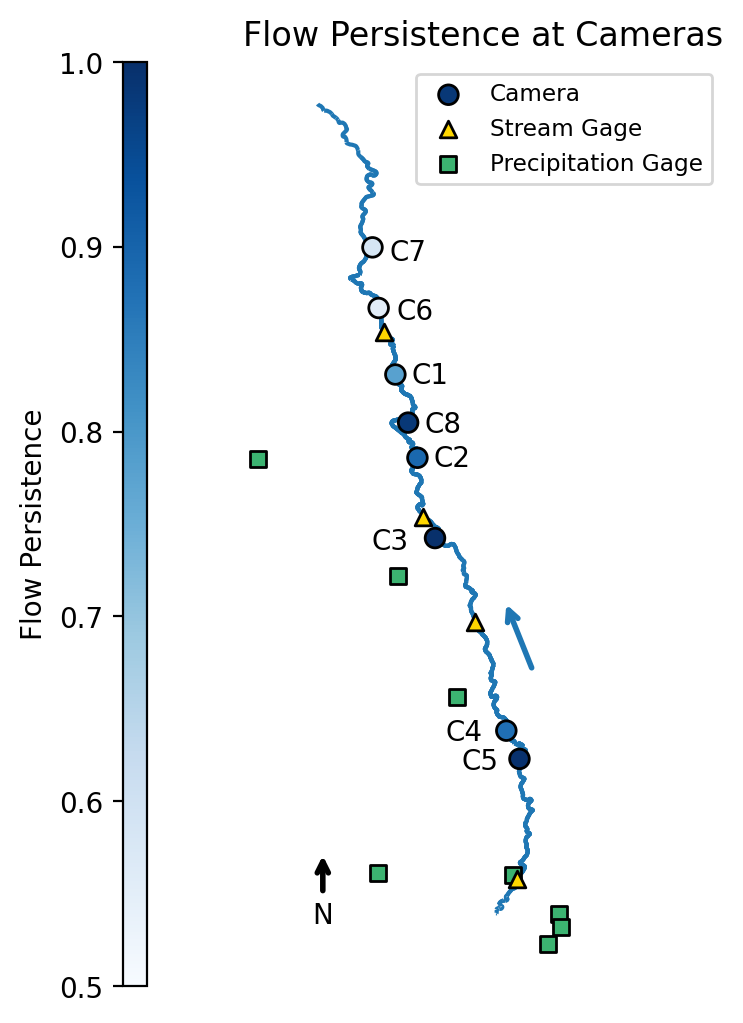

In [ ]:
fig, ax = plt.subplots(figsize = (8, 6))

ax.annotate("", xy = (-110.12, 31.57), xytext = (-110.1, 31.52), arrowprops = dict(arrowstyle = "->", color = "tab:blue", linewidth = 2), zorder = 3)
ax.annotate("N", xy = (-110.243, 31.4), xytext = (-110.25, 31.35), arrowprops = dict(arrowstyle = "->", color = "black", linewidth = 2), zorder = 3)

norm = mpl.colors.Normalize(vmin = 0.5, vmax = 1)

streamline.plot(ax = ax, zorder = 1)
persistence.plot(column = "Persistence", ax = ax, cmap = "Blues", markersize = 50, norm = norm, edgecolor = "black", label = "Camera", zorder = 3)
gages.plot(ax = ax, marker = "^", color = "gold", edgecolor = "black", label = "Stream Gage", zorder = 2)
precip_gages.plot(ax = ax, marker = "s", color = "mediumseagreen", edgecolor = "black", label = "Precipitation Gage")

ax.set_title("Flow Persistence at Cameras")
ax.set_xlim(ax.get_xlim()[0], ax.get_xlim()[1] + 0.1)
ax.legend(loc = "upper right", fontsize = "small")

divider = make_axes_locatable(ax) # understands size and position of axes
cax = divider.append_axes("left", size = "5%") # adds new axis
sm = mpl.cm.ScalarMappable(cmap = "Blues", norm = norm) # maps values to colors for colorbar
cbar = fig.colorbar(sm, cax = cax)
cbar.set_label("Flow Persistence")
cbar.ax.yaxis.set_label_position("left")
cbar.ax.yaxis.set_ticks_position("left")

ax.text(-110.198, 31.8, "C7")
ax.text(-110.193, 31.76, "C6")
ax.text(-110.183, 31.716, "C1")
ax.text(-110.174, 31.683, "C8")
ax.text(-110.168, 31.66, "C2")
ax.text(-110.21, 31.604, "C3")
ax.text(-110.16, 31.474, "C4")
ax.text(-110.149, 31.455, "C5")

ax.set_axis_off()

%config InlineBackend.figure_format = "retina"

# plt.savefig("flow_persistence.png", format = "png", dpi = 300, bbox_inches = "tight")

In [6]:
monthly = flow # average monthly flow code by site
monthly = monthly[~monthly["Site"].isin(["Cottonwood", "Escalante", "FairbankNorth", "LewisSprings"])] # removes cameras with incomplete data
monthly = monthly.to_crs(epsg = 32612)
monthly = monthly.sort_values(by = "Latitude")
river = LineString(monthly.geometry.tolist())

def river_km(point):
    return river.project(point)/1000

monthly["River Kilometer"] = monthly["geometry"].apply(river_km)

monthly["Month"] = monthly["Date"].dt.month
wy_month = {1: 10, 2: 11, 3: 12, 4: 1, 5: 2, 6: 3, 7: 4, 8: 5, 9: 6, 10: 7, 11: 8, 12: 9}
monthly["Month"] = monthly["Month"].map(wy_month)
monthly["Day"] = monthly["Date"].dt.day

monthly["X"] = monthly["Month"] + (monthly["Day"] - 1) / 30
monthly = (
    monthly
    .groupby(["Site", "Month", "Day"])
    .agg({"Flow Code": "mean", "River Kilometer": "first", "X": "first"})
    .reset_index()
)

c:\Users\tiffa\anaconda3\Lib\site-packages\shapely\linear.py:88: RuntimeWarning: invalid value encountered in line_locate_point
  return lib.line_locate_point(line, other)


In [7]:
yearly = flow # average yearly flow persistence by site
yearly = yearly[~yearly["Site"].isin(["Cottonwood", "Escalante", "FairbankNorth", "LewisSprings"])]
yearly = yearly.to_crs(epsg = 32612)
yearly = yearly.sort_values(by = "Latitude")
river = LineString(yearly.geometry.tolist())
yearly["River Kilometer"] = yearly["geometry"].apply(river_km)

def water_year(row):
    if row["Date"].month >= 10:
        return row["Date"].year + 1
    return row["Date"].year

yearly["Water Year"] = yearly.apply(water_year, axis = 1)

def fp(series):
    monitored = series.isin([0, 1, 2]).sum()
    wet = series.isin([1, 2]).sum()
    if monitored == 0:
        return np.nan
    return wet / monitored

yearly_fp = (
    yearly
    .groupby(["Site", "Water Year"])["Flow Code"]
    .agg(fp)
    .reset_index()
)

yearly_river_km = (
    yearly
    .groupby(["Site", "Water Year"])["River Kilometer"]
    .first()
    .reset_index()
)

yearly = pd.merge(yearly_fp, yearly_river_km, on = ["Site", "Water Year"])
yearly.groupby("Site")["River Kilometer"].first()

c:\Users\tiffa\anaconda3\Lib\site-packages\shapely\linear.py:88: RuntimeWarning: invalid value encountered in line_locate_point
  return lib.line_locate_point(line, other)


Site
Boquillas             26.311268
CharlestonMesquite    23.601846
Contention            35.129527
Fairbank              30.017126
Hereford               0.000000
Hunter                 2.282820
Moson                 17.464322
St.David              39.702600
Name: River Kilometer, dtype: float64

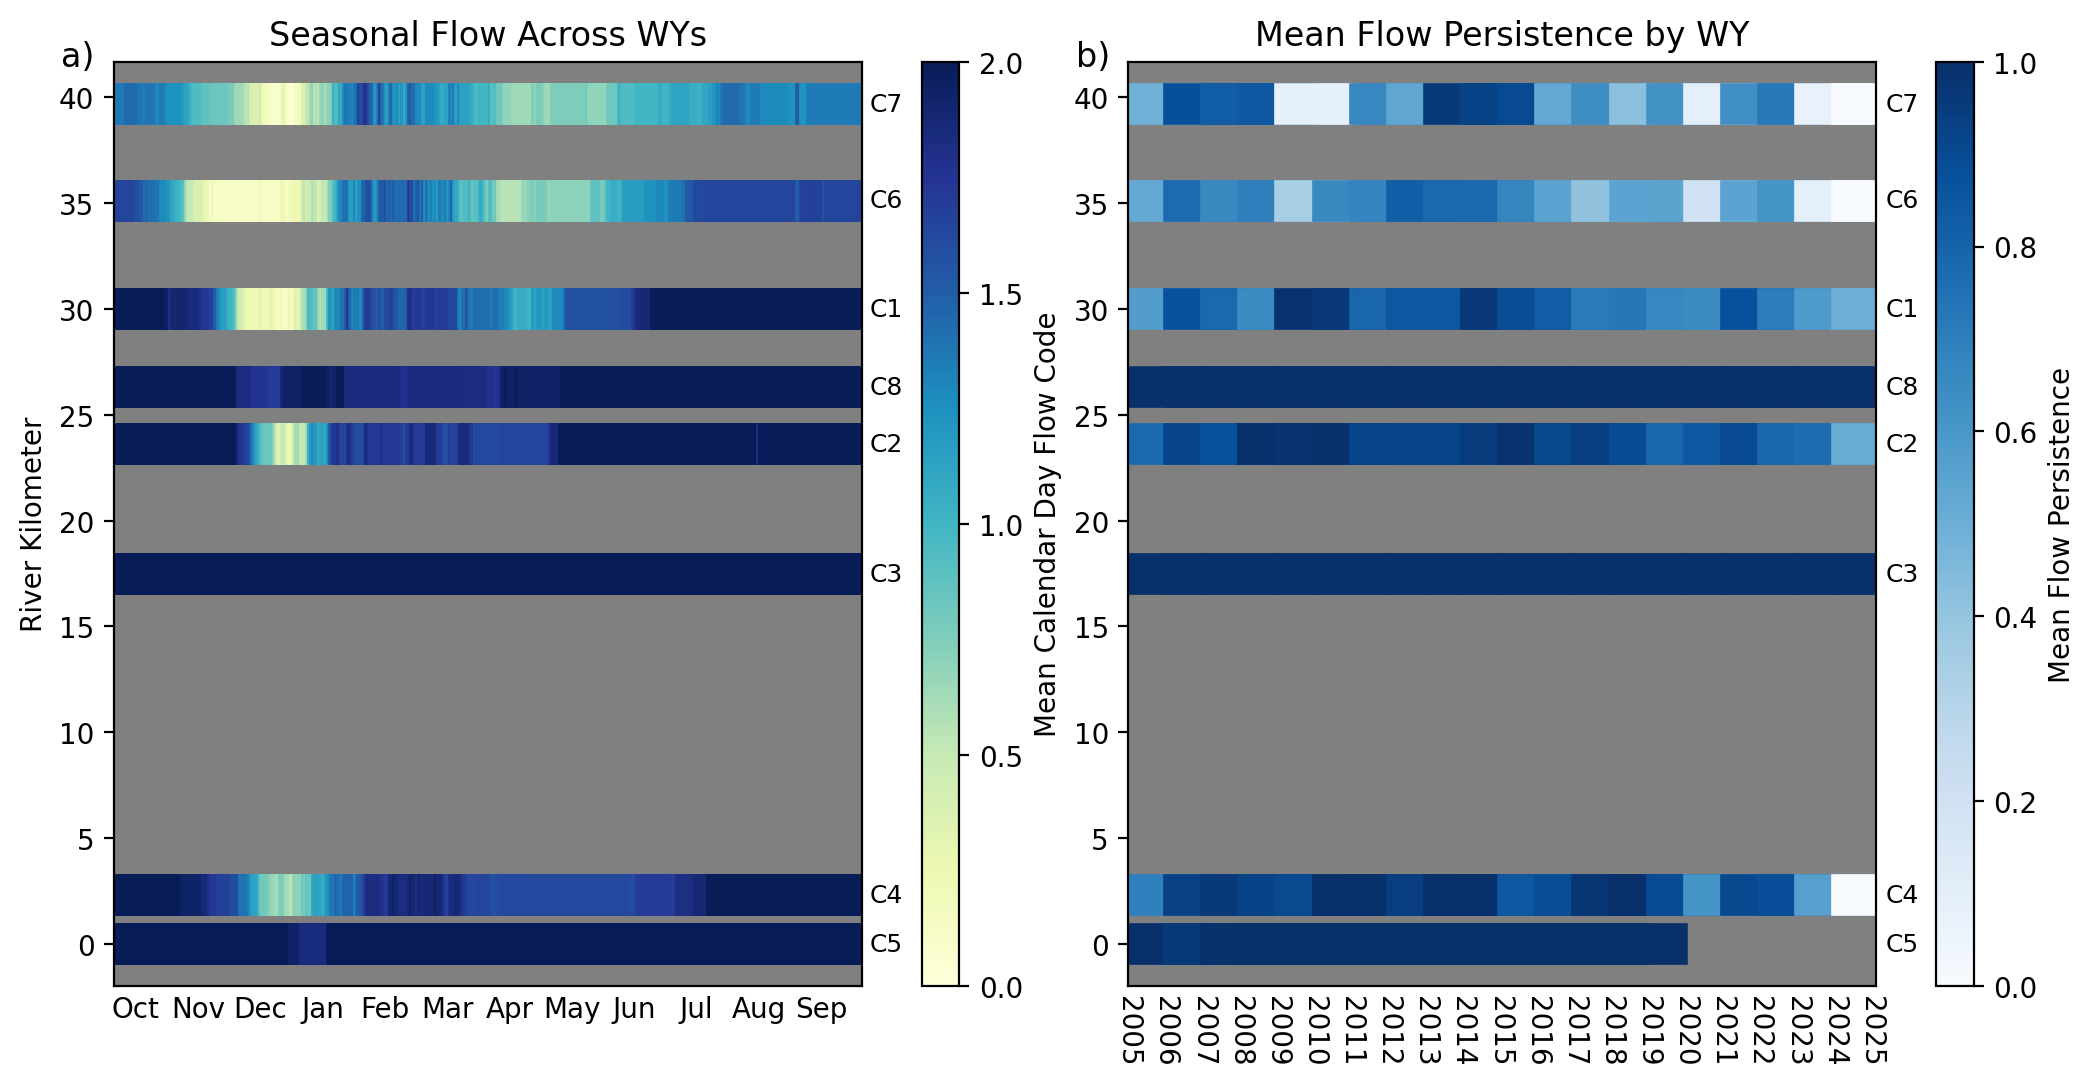

In [8]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (12, 6))

cmap = plt.get_cmap("YlGnBu")
norm = mcolors.Normalize(vmin = 0, vmax = 2)

ax1.set_title("Seasonal Flow Across WYs")
ax1.text(-0.2, 41.5, "a)", fontsize = 12)
ax1.set_facecolor("gray")

ax1.set_xlim(0.65, 12.65)
ax1.set_xticks(range(1, 13))
ax1.set_xticklabels(["Oct", "Nov", "Dec", "Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep"])
ax1.tick_params(axis = "x", length = 0)
ax1.set_ylabel("River Kilometer")

for i in range(len(monthly)):
    ax1.plot([monthly["X"].iloc[i] - 0.015, monthly["X"].iloc[i] + 0.015], [monthly["River Kilometer"].iloc[i], monthly["River Kilometer"].iloc[i]], color = cmap(norm(monthly["Flow Code"].iloc[i])), linewidth = 15)

divider = make_axes_locatable(ax1)
cax = divider.append_axes("right", size = "5%", pad = 0.3)
sm = mpl.cm.ScalarMappable(cmap = "YlGnBu", norm = norm)
cbar = fig.colorbar(sm, cax = cax, ticks = [0, 0.5, 1, 1.5, 2])
cbar.set_label("Mean Calendar Day Flow Code")

ax1.text(13.3, 26.311268, "C8", va = "center", ha = "right", fontsize = 9)
ax1.text(13.3, 23.601846, "C2", va = "center", ha = "right", fontsize = 9)
ax1.text(13.3, 35.129527, "C6", va = "center", ha = "right", fontsize = 9)
ax1.text(13.3, 30.017126, "C1", va = "center", ha = "right", fontsize = 9)
ax1.text(13.3, 0, "C5", va = "center", ha = "right", fontsize = 9)
ax1.text(13.3, 2.282820, "C4", va = "center", ha = "right", fontsize = 9)
ax1.text(13.3, 17.464322, "C3", va = "center", ha = "right", fontsize = 9)
ax1.text(13.3, 39.702600, "C7", va = "center", ha = "right", fontsize = 9)

cmap2 = plt.get_cmap("Blues")
norm2 = mcolors.Normalize(vmin = 0, vmax = 1)

ax2.set_title("Mean Flow Persistence by WY")
ax2.text(2003.6, 41.5, "b)", fontsize = 12)
ax2.set_facecolor("gray")

ax2.set_xlim(2005, 2025.15)
ax2.set_xticks(range(2005, 2026))
ax2.tick_params(axis = "x", length = 0, labelrotation = 270)

for i in range(len(yearly)):
    ax2.plot([yearly["Water Year"].iloc[i] - 0.5, yearly["Water Year"].iloc[i] + 0.5], [yearly["River Kilometer"].iloc[i], yearly["River Kilometer"].iloc[i]], color = cmap2(norm2(yearly["Flow Code"].iloc[i])), linewidth = 15)

divider = make_axes_locatable(ax2)
cax = divider.append_axes("right", size = "5%", pad = 0.3)
sm = mpl.cm.ScalarMappable(cmap = "Blues", norm = norm2)
cbar = fig.colorbar(sm, cax = cax, ticks = [0, 0.2, 0.4, 0.6, 0.8, 1])
cbar.set_label("Mean Flow Persistence")

ax2.text(2026.3, 26.311268, "C8", va = "center", ha = "right", fontsize = 9)
ax2.text(2026.3, 23.601846, "C2", va = "center", ha = "right", fontsize = 9)
ax2.text(2026.3, 35.129527, "C6", va = "center", ha = "right", fontsize = 9)
ax2.text(2026.3, 30.017126, "C1", va = "center", ha = "right", fontsize = 9)
ax2.text(2026.3, 0, "C5", va = "center", ha = "right", fontsize = 9)
ax2.text(2026.3, 2.282820, "C4", va = "center", ha = "right", fontsize = 9)
ax2.text(2026.3, 17.464322, "C3", va = "center", ha = "right", fontsize = 9)
ax2.text(2026.3, 39.702600, "C7", va = "center", ha = "right", fontsize = 9)

%config InlineBackend.figure_format = "retina"

# plt.savefig("fine_reach.png", format = "png", dpi = 300, bbox_inches = "tight")

In [9]:
names = {"Boquillas": 8, "CharlestonMesquite": 2, "Contention": 6, "Cottonwood": None, "Escalante": None, "Fairbank": 1, "FairbankNorth": None, "Hereford": 5, "Hunter": 4, "LewisSprings": None, "Moson": 3, "St.David": 7}
old_names = {"Boquillas": 8, "CharlestonMesquite": 2, "Contention": 6, "Fairbank": 1, "Hereford": 5, "Hunter": 4, "Moson": 3, "St.David": 7}
years = range(2006, 2026)

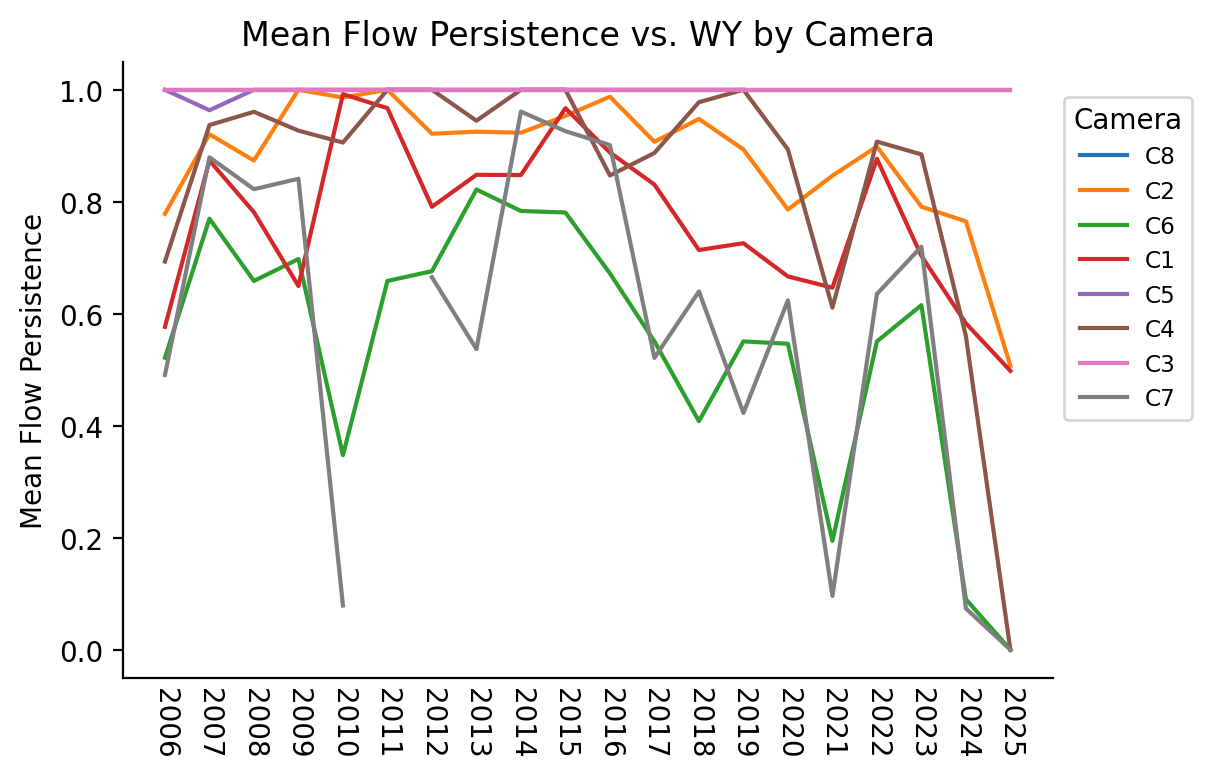

In [ ]:
fig, ax = plt.subplots(figsize = (6, 4))
pivot = yearly.pivot(index = "Water Year", columns = "Site", values = "Flow Code")

for site in pivot.columns:
    ax.plot(pivot.index, pivot[site], label = "C" + str(names[site]))

ax.spines[["top", "right"]].set_visible(False)
ax.set_title("Mean Flow Persistence vs. WY by Camera")
ax.set_ylabel("Mean Flow Persistence")
ax.legend(title = "Camera", loc = "lower left", bbox_to_anchor = (1, 0.4), fontsize = "small")
ax.set_xticks(range(2006, 2026))
ax.tick_params(axis = "x", length = 0, labelrotation = 270)

%config InlineBackend.figure_format = "retina"

# plt.savefig("fp_line.png", format = "png", dpi = 300, bbox_inches = "tight")

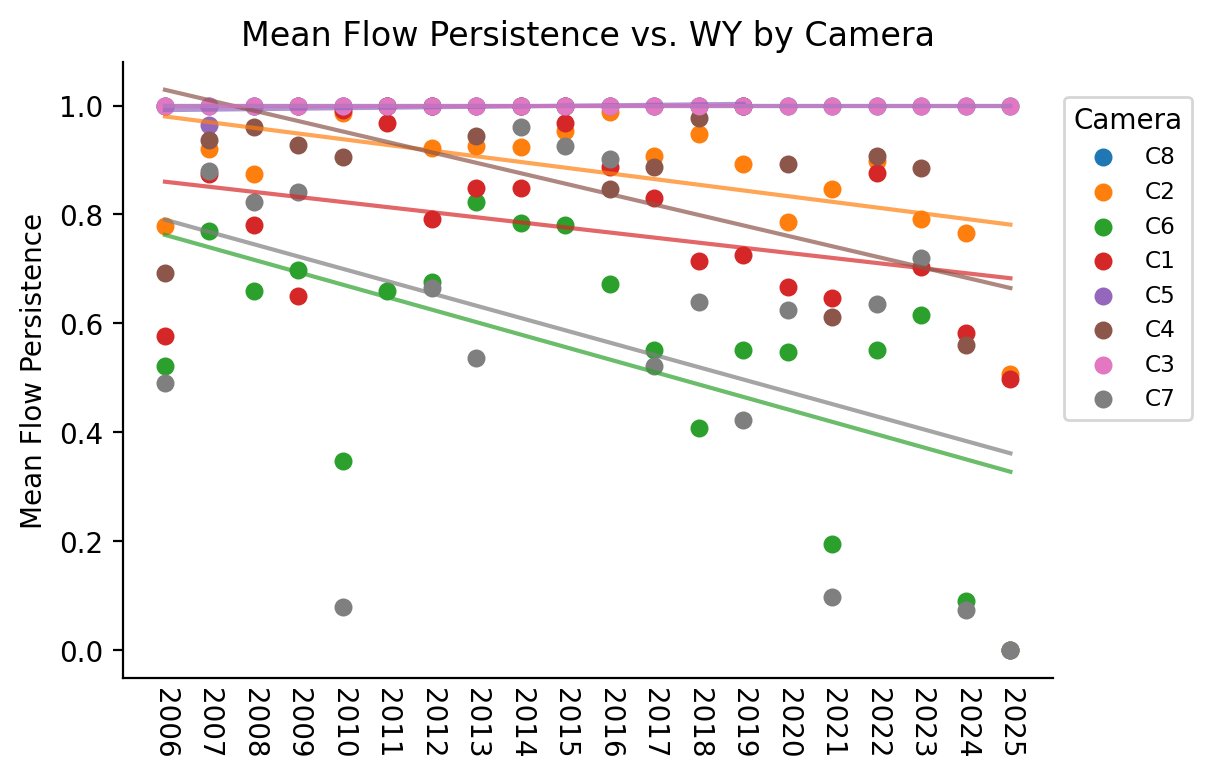

In [11]:
fig, ax = plt.subplots(figsize = (6, 4))
pivot = yearly.pivot(index = "Water Year", columns = "Site", values = "Flow Code")

for site in pivot.columns:
    data = pivot[site].dropna()
    x = data.index.values
    y = data.values

    scatter = ax.scatter(x, y, label = "C" + str(names[site]), s = 30)
    color = scatter.get_facecolor()[0]

    slope, intercept, _, _, _ = linregress(x, y)
    fit = intercept + slope * x
    ax.plot(x, fit, color = color, alpha = 0.7)

ax.spines[["top", "right"]].set_visible(False)
ax.set_title("Mean Flow Persistence vs. WY by Camera")
ax.set_ylabel("Mean Flow Persistence")
ax.legend(title = "Camera", loc = "lower left", bbox_to_anchor = (1, 0.4), fontsize = "small")
ax.set_xticks(range(2006, 2026))
ax.tick_params(axis = "x", length = 0, labelrotation = 270)

%config InlineBackend.figure_format = "retina"

# plt.savefig("fp_lm.png", format = "png", dpi = 300, bbox_inches = "tight")

In [12]:
cameras = flow
cameras = cameras[~cameras["Site"].isin(["Cottonwood", "Escalante", "FairbankNorth", "LewisSprings"])]
cameras["Water Year"] = cameras.apply(water_year, axis = 1)
cameras["Month"] = cameras["Date"].dt.month
cameras["Month"] = cameras["Month"].map(wy_month)
cameras["Day"] = cameras["Date"].dt.day
cameras["X"] = cameras["Month"] + (cameras["Day"] - 1) / 30
years = sorted(cameras["Water Year"].unique())

c:\Users\tiffa\anaconda3\Lib\site-packages\geopandas\geodataframe.py:1968: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\tiffa\anaconda3\Lib\site-packages\geopandas\geodataframe.py:1968: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\tiffa\anaconda3\Lib\site-packages\geopandas\geodataframe.py:1968: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer]

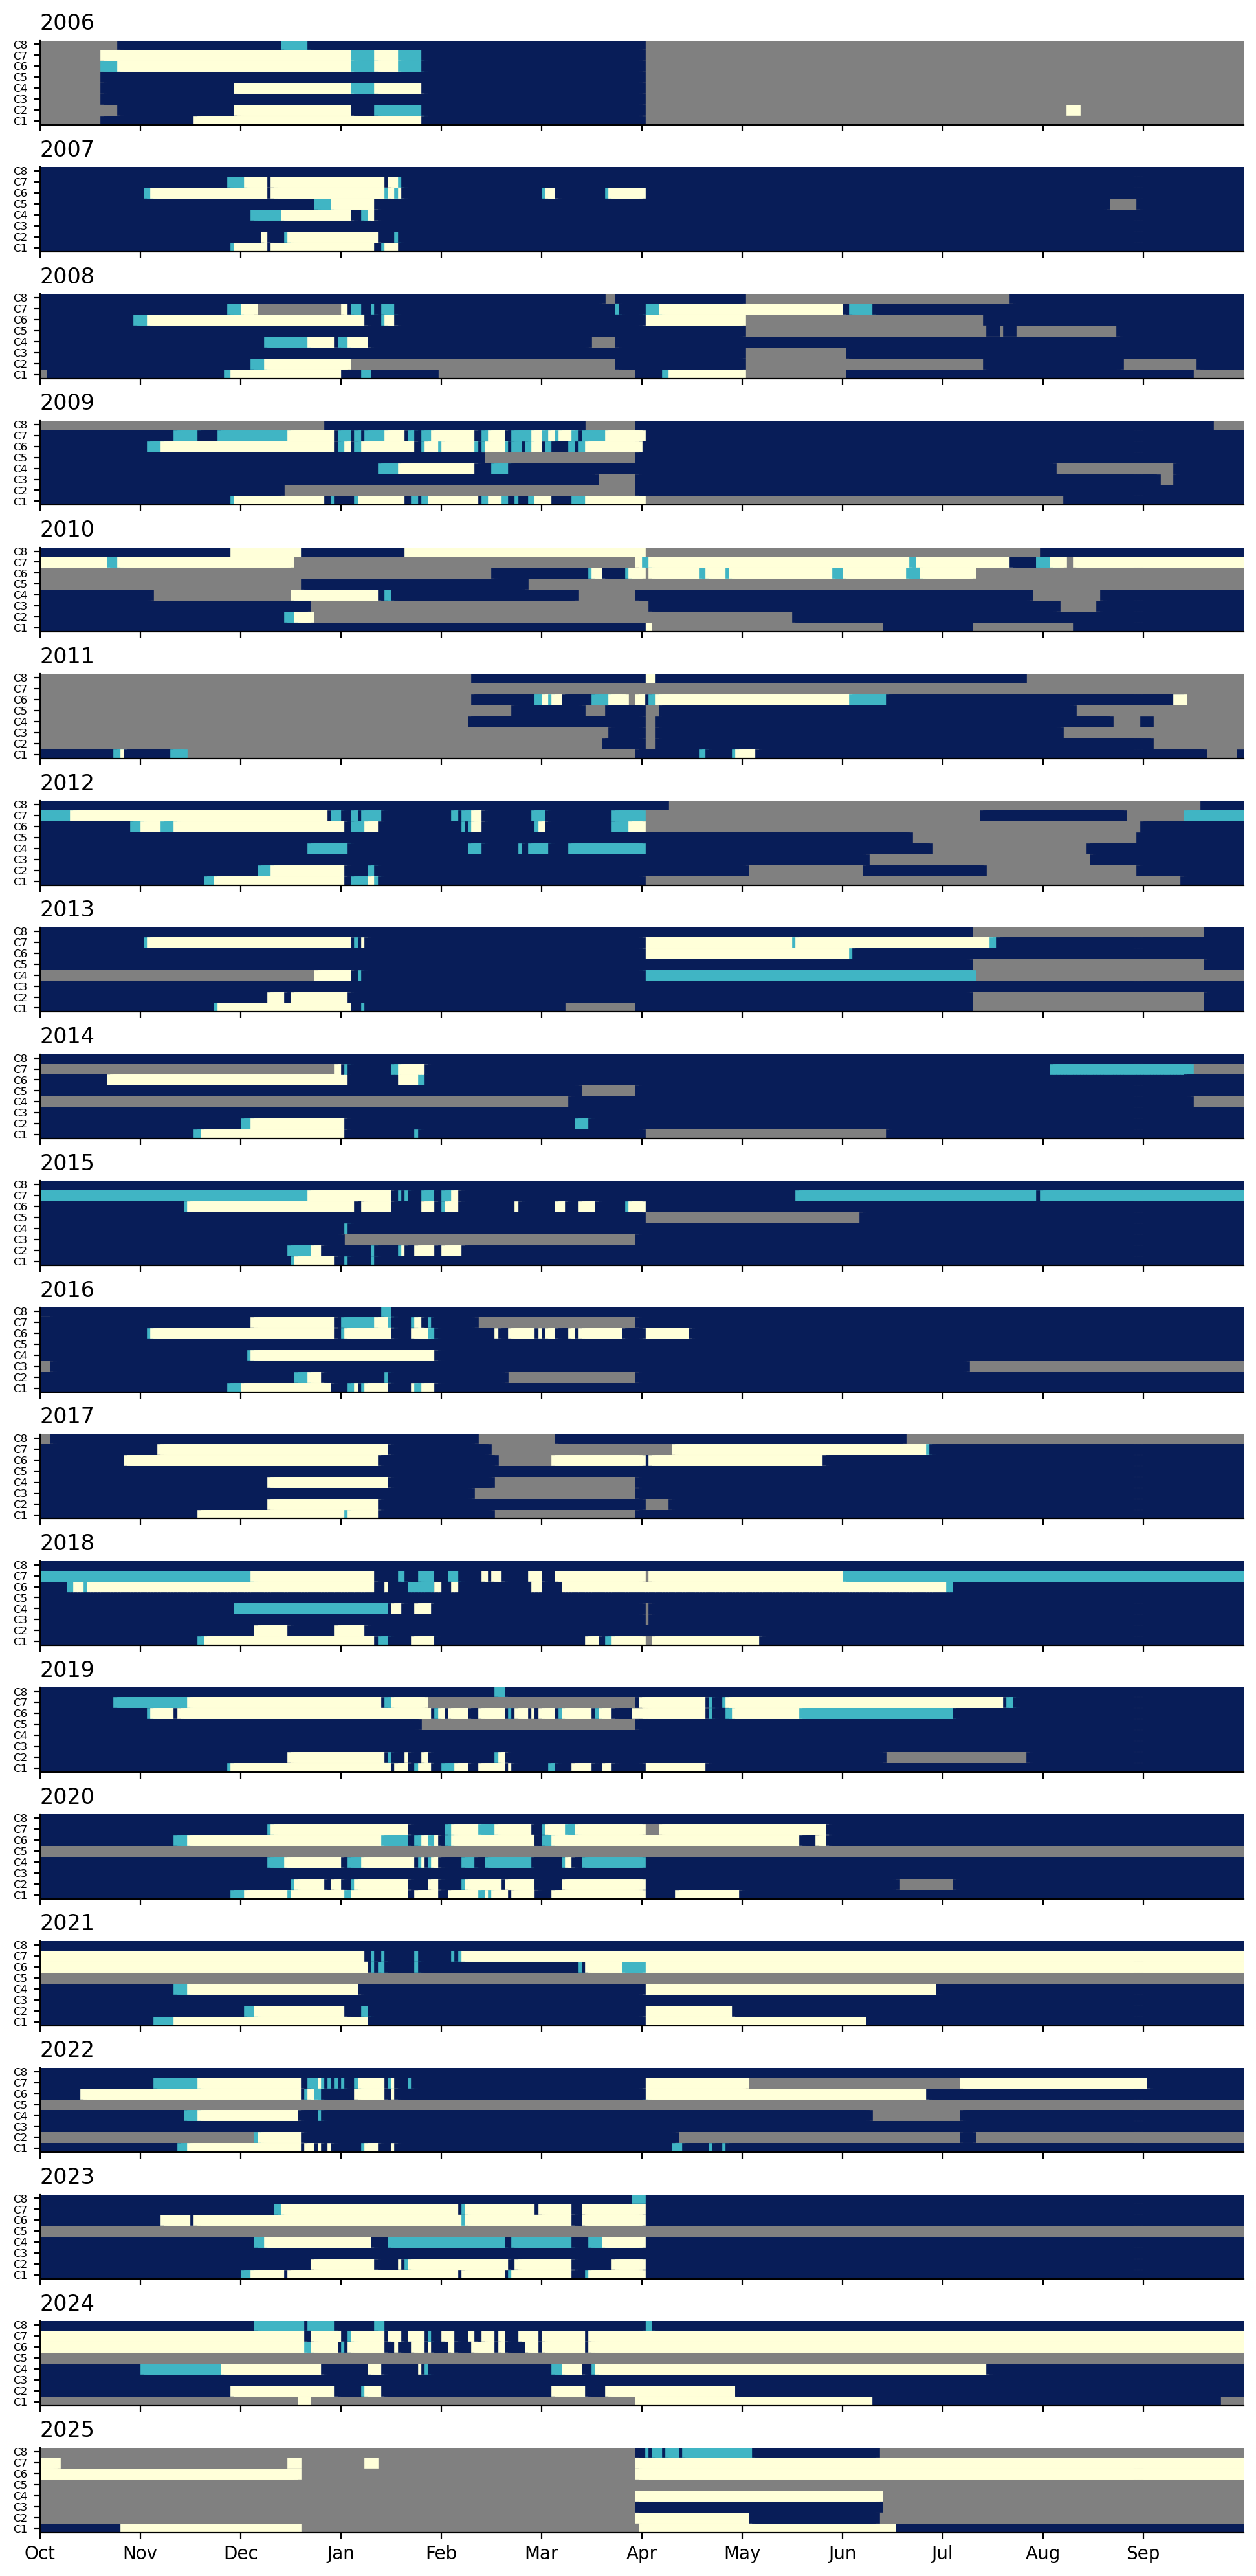

In [13]:
fig, axes = plt.subplots(len(years), 1, figsize = (12, len(years) * 1.25), sharex = True)

cmap = plt.get_cmap("YlGnBu")
norm = mcolors.Normalize(vmin = 0, vmax = 2)

for i in range(len(years)):
    ax = axes[i]
    ax.set_title(years[i], loc = "left")
    ax.set_facecolor("gray")
    ax.spines[["top","right"]].set_visible(False)
    ax.set_xlim(1, 13)
    ax.set_xticks(range(1, 13))
    ax.set_yticks(range(1, 9))
    ax.set_yticklabels(["C1", "C2", "C3", "C4", "C5", "C6", "C7", "C8"], fontsize = 6)
    
    year = cameras[cameras["Water Year"] == years[i]]
    for j in range(len(year)):
        ax.plot([year["X"].iloc[j] - 0.015, year["X"].iloc[j] + 0.015], [old_names[year["Site"].iloc[j]], old_names[year["Site"].iloc[j]]], color = cmap(norm(year["Flow Code"].iloc[j])), linewidth = 6)

axes[len(years) - 1].set_xticklabels(["Oct", "Nov", "Dec", "Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep"])

plt.subplots_adjust(hspace = 0.5)

%config InlineBackend.figure_format = "retina"

# plt.savefig("cameras_yearly.png", format = "png", dpi = 300, bbox_inches = "tight")

In [ ]:
locations = (
    flow
    .drop_duplicates(subset = ["Longitude", "Latitude"])
    .dropna(subset = ["Longitude", "Latitude"])
)

alldaymet = []
for i in range(len(locations)): # pull daymet data at camera locations
    daymet_this = daymetpy.daymet_timeseries(lon = locations.geometry.values[i].x, 
                               lat = locations.geometry.values[i].y, 
                               start_year = 2006, end_year = 2025)
    daymet_this["x"] = locations.geometry.values[i].x
    daymet_this["y"] = locations.geometry.values[i].y
    daymet_this["site"] = locations["Site"][i]
    alldaymet.append(daymet_this)
alldaymet = pd.concat(alldaymet)

alldaymet["Date"] = pd.to_datetime(alldaymet["year"].astype(str), format = "%Y") + pd.to_timedelta(alldaymet["yday"] - 1, unit = "D")
alldaymet["Water Year"] = alldaymet.apply(water_year, axis = 1)
alldaymet["Cumulative"] = alldaymet.groupby(["site", "Water Year"])["prcp"].cumsum()
alldaily = alldaymet.groupby(["Water Year", "Date"])["prcp"].mean().reset_index()
wytotal = alldaily.groupby("Water Year")["prcp"].sum().reset_index()

In [ ]:
streamflow, metadata = nwis.get_dv(sites = gage_numbers, start = start_date, end = end_date, parameterCd = "00060", statCd = "00003")
streamflow = streamflow.reset_index()

def water_date(date): # adjusts date wrt water year
    if date.month >= 10:
        year = date.year + 1
    else:
        year = date.year
    return pd.Timestamp(f"{year}-01-01") + (date - pd.Timestamp(f"{year}-10-01",  tz = date.tzinfo))

streamflow["water_date"] = streamflow["datetime"].apply(water_date)

In [16]:
alldaymet["water_date"] = alldaymet["Date"].apply(water_date)

In [17]:
precip_whip["water_date"] = precip_whip["datetime_utc"].apply(water_date)
precip_whip = precip_whip.rename(columns = {"datetime_utc": "Date"})
precip_whip["Water Year"] = precip_whip.apply(water_year, axis = 1)
precip_whip["reported"] = precip_whip["Water Year"].map(precip_whip.groupby("Water Year")["water_date"].nunique())
daily = precip_whip.groupby(["Water Year", "water_date", "reported"])["precipitation"].mean().reset_index()
daily["Cumulative"] = daily.groupby("Water Year")["precipitation"].cumsum() * (365 / daily["reported"]) # adjust for missing days
daily[["Water Year", "reported"]].drop_duplicates()

,Water Year,reported
0,2021,62
62,2022,111
173,2023,116
289,2024,123
412,2025,45


In [18]:
whipwytotal = daily.groupby(["Water Year", "reported"])["precipitation"].sum().reset_index()
whipwytotal["precipitation"] = whipwytotal["precipitation"] * (365 / whipwytotal["reported"])

In [19]:
streamflow["00060_Mean"] = (streamflow["00060_Mean"] * 28316846.711688 * 86400) / (1740 * 2.59 * 10**9) # convert to mm/day

In [20]:
across_cameras = flow # average daily flow persistence across all cameras
across_cameras["water_date"] = across_cameras["Date"].apply(water_date) 
across_cameras = across_cameras.groupby(["water_date"])["Flow Code"].agg(fp).reset_index()

In [21]:
seasons = []
for year in range(2005, 2026):
    start = pd.Timestamp(f"{year}-08-15")
    end = pd.Timestamp(f"{year + 1}-03-01")
    seasons.append((start, end))

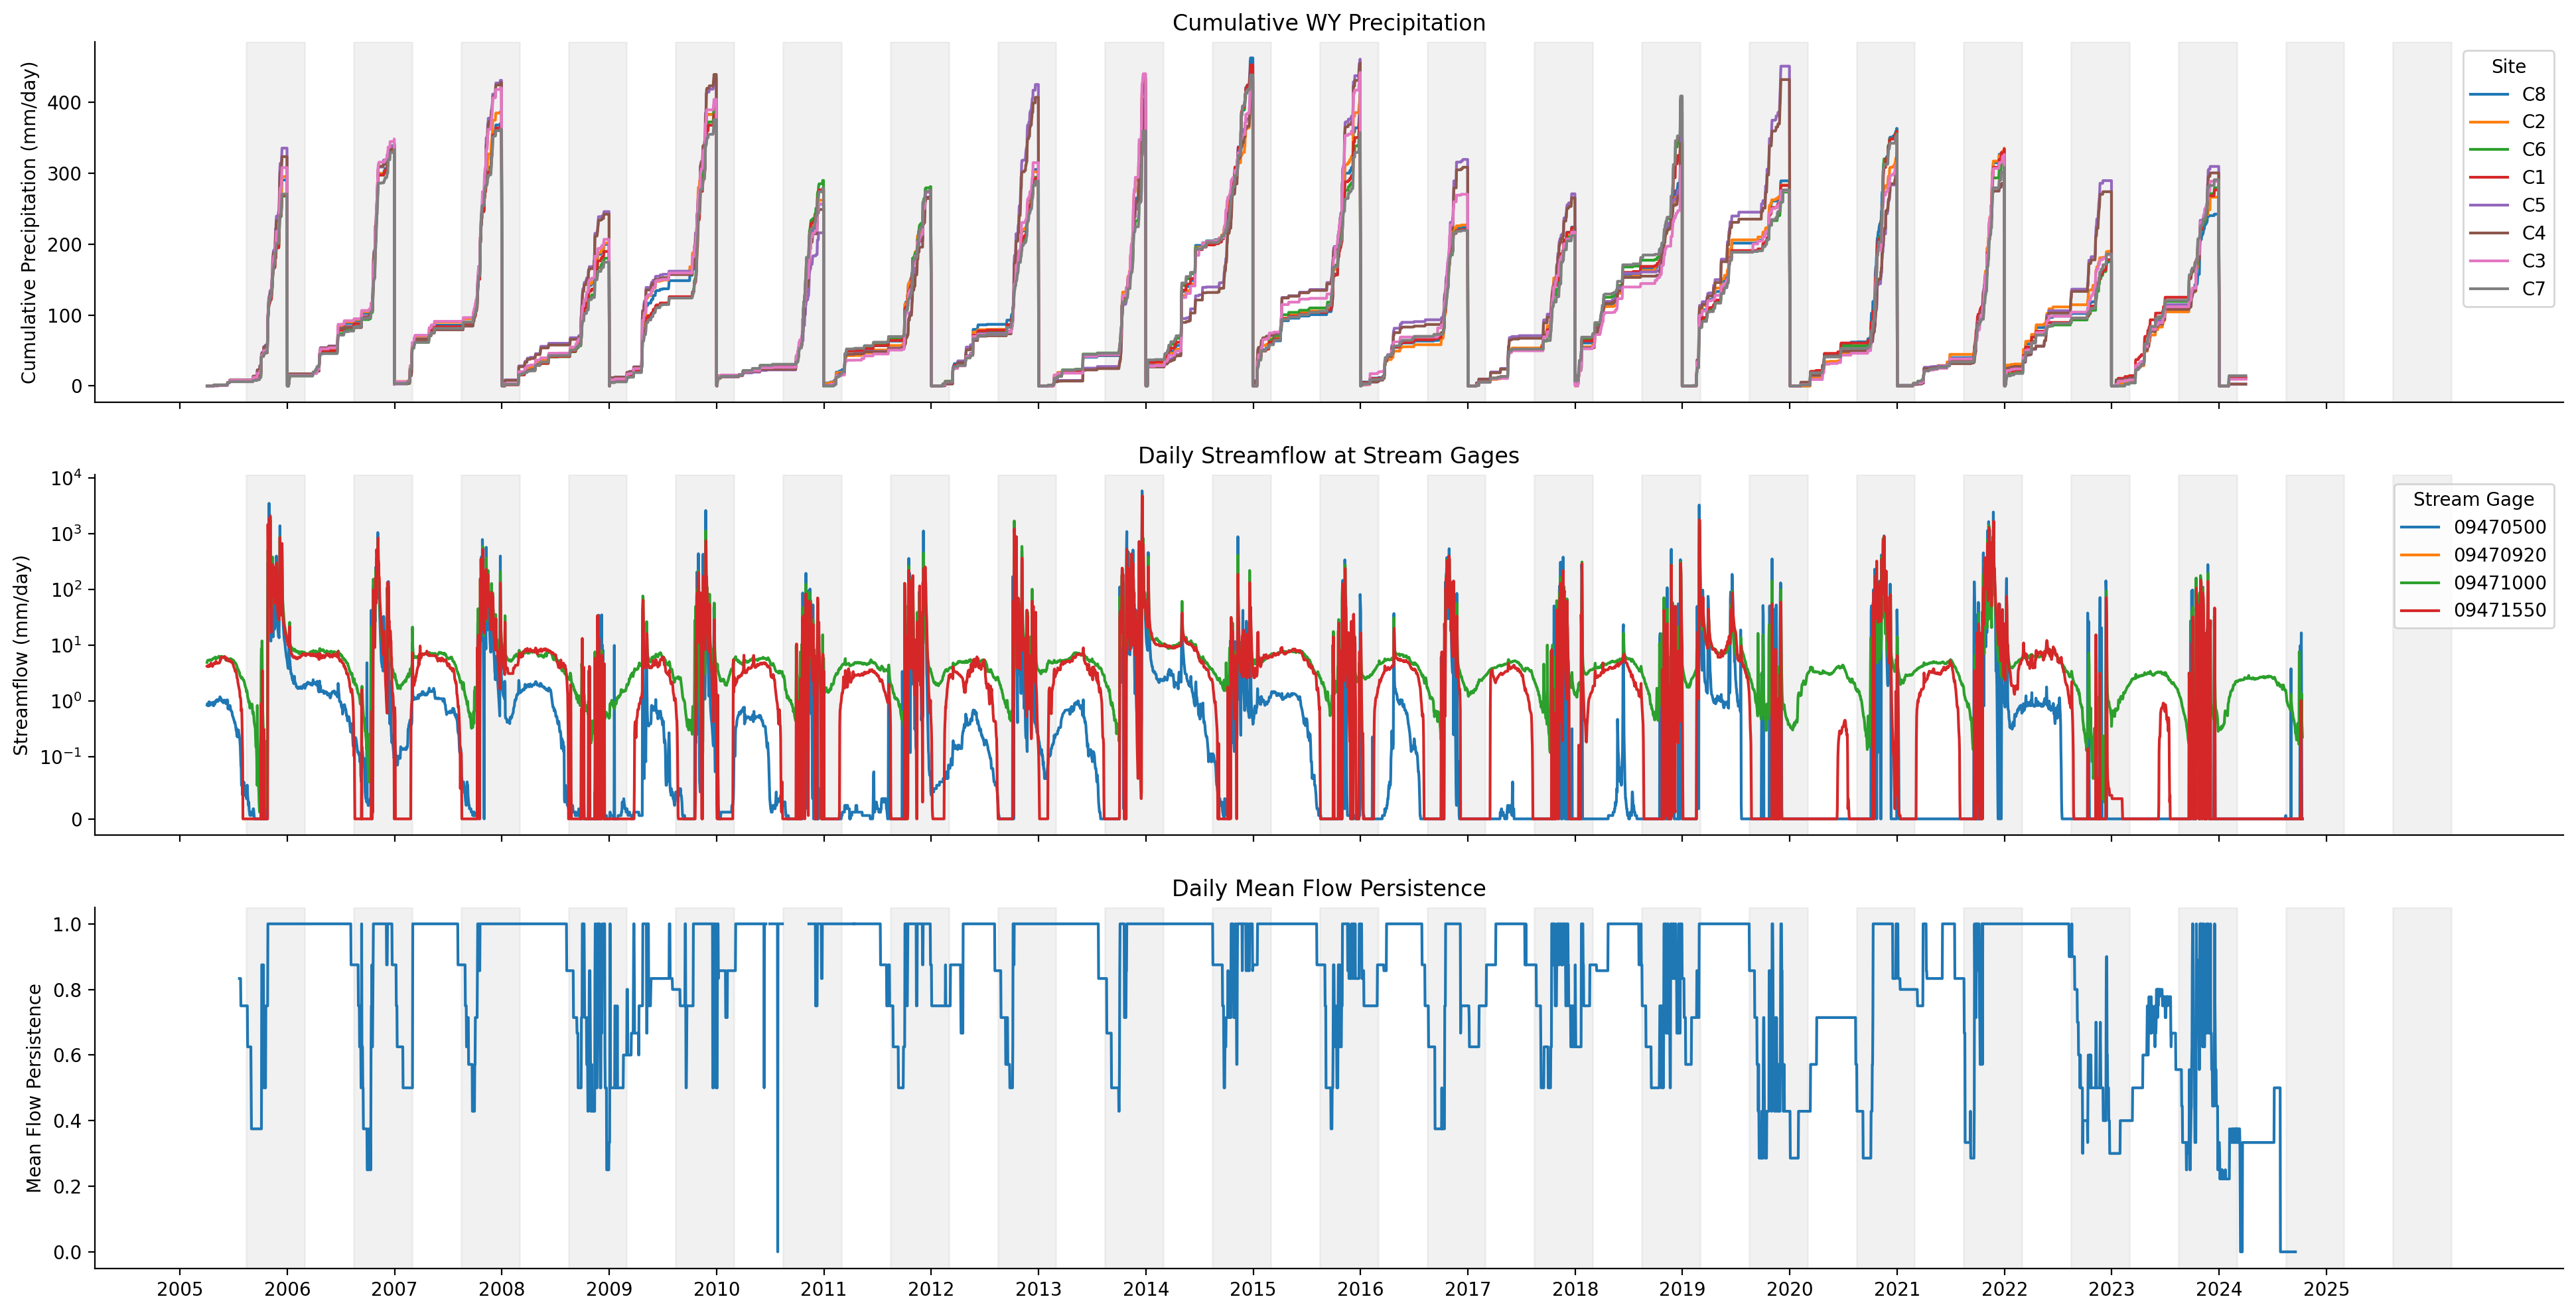

In [22]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize = (24, 12), sharex = True)

for start, end in seasons:
    for ax in [ax1, ax2, ax3]:
        ax.axvspan(start, end, color = "lightgray", alpha = 0.3)

ax1.set_title("Cumulative WY Precipitation")
ax1.spines[["top", "right"]].set_visible(False)

for site in locations["Site"]:
    site_data = alldaymet[alldaymet["site"] == site]
    ax1.plot(site_data["water_date"], site_data["Cumulative"], label = "C" + str(names[site]))

ax1.set_ylabel("Cumulative Precipitation (mm/day)")
ax1.set_xticks([pd.Timestamp(f"{y}-01-01") for y in range(2005, 2026)])
ax1.legend(title = "Site")

ax2.set_title("Daily Streamflow at Stream Gages")
ax2.spines[["top", "right"]].set_visible(False)

for site in gage_numbers:
    gage_data = streamflow[streamflow["site_no"] == site]
    ax2.plot(gage_data["water_date"], gage_data["00060_Mean"], label = site)

ax2.set_yscale("symlog", linthresh = 0.1)
ax2.set_ylabel("Streamflow (mm/day)")
ax2.set_xticks([pd.Timestamp(f"{y}-01-01") for y in range(2005, 2026)])
ax2.legend(title = "Stream Gage")

ax3.set_title("Daily Mean Flow Persistence")
ax3.spines[["top", "right"]].set_visible(False)
ax3.plot(across_cameras["water_date"], across_cameras["Flow Code"])

ax3.set_ylabel("Mean Flow Persistence")
ax3.set_xticks([pd.Timestamp(f"{y}-01-01") for y in range(2005, 2026)])
ax3.set_xticklabels(range(2005, 2026))

%config InlineBackend.figure_format = "retina"

# plt.savefig("precip_sf_persist.png", format = "png", dpi = 300, bbox_inches = "tight")

In [23]:
precip_agg = alldaymet.groupby("water_date")["Cumulative"].mean().reset_index()

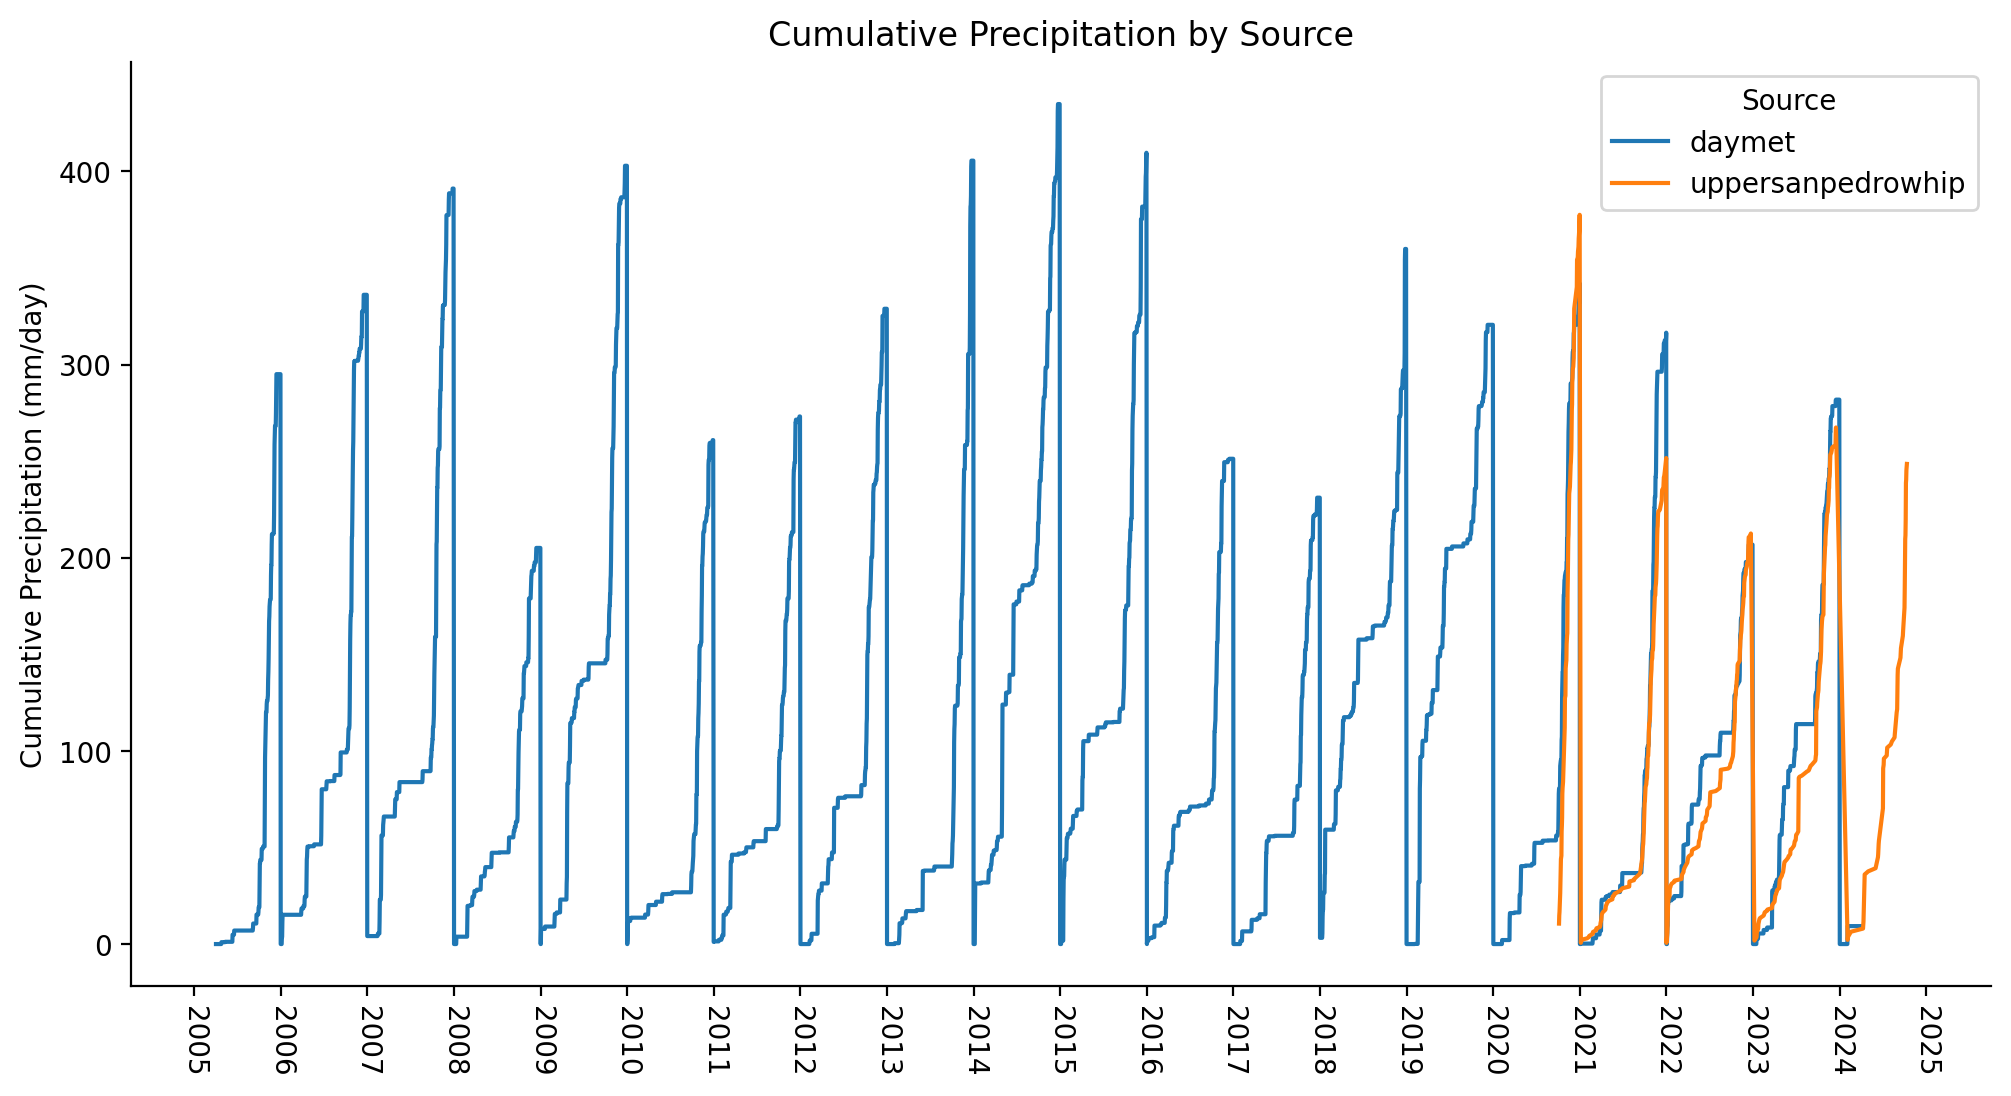

In [24]:
fig, ax = plt.subplots(figsize = (12, 6))
ax.spines[["top", "right"]].set_visible(False)

ax.set_title("Cumulative Precipitation by Source")
ax.set_ylabel("Cumulative Precipitation (mm/day)")

ax.plot(precip_agg["water_date"], precip_agg["Cumulative"], label = "daymet")
ax.plot(daily["water_date"], daily["Cumulative"] * 25.4, label = "uppersanpedrowhip")

ax.set_xticks([pd.Timestamp(f"{y}-01-01") for y in range(2005, 2026)])
ax.set_xticklabels(range(2005, 2026))
ax.tick_params(axis = "x", labelrotation = 270)

ax.legend(title = "Source")

%config InlineBackend.figure_format = "retina"

# plt.savefig("daymet_whip.png", format = "png", dpi = 300, bbox_inches = "tight")

In [25]:
wyt = wytotal.merge(whipwytotal[["Water Year", "precipitation"]], on = "Water Year")

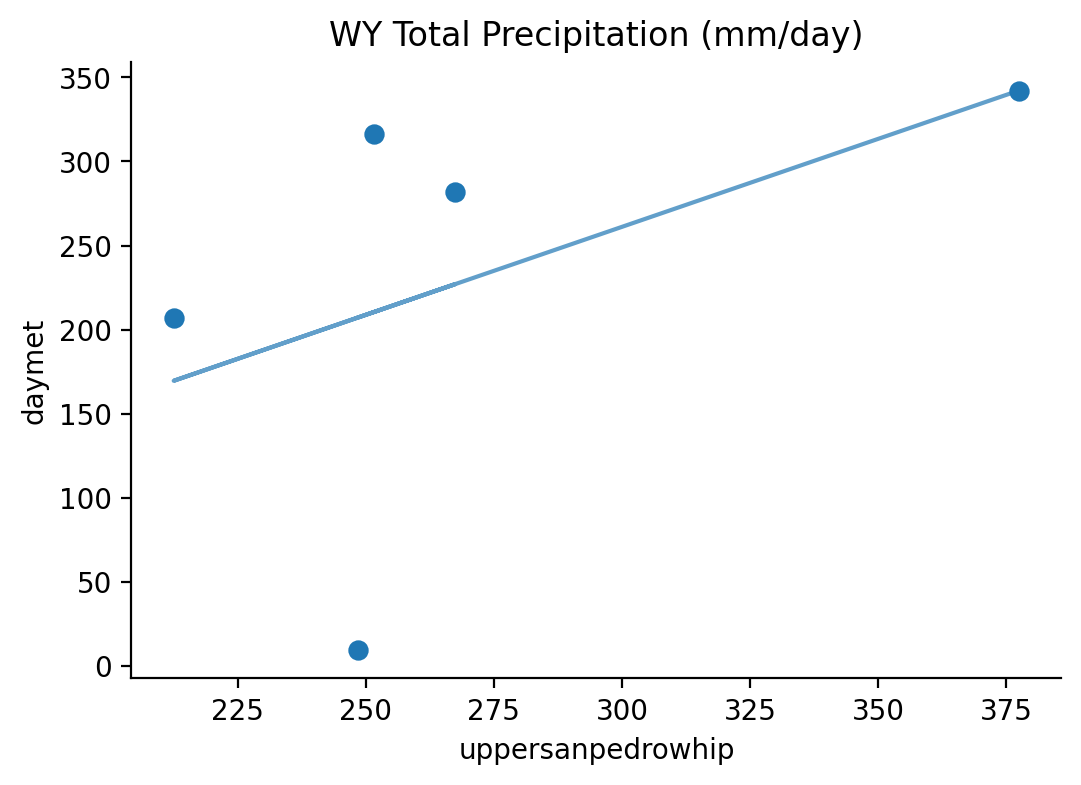

In [26]:
fig, ax = plt.subplots(figsize = (6, 4))
ax.spines[["top", "right"]].set_visible(False)

ax.set_title("WY Total Precipitation (mm/day)")
ax.set_ylabel("daymet")
ax.set_xlabel("uppersanpedrowhip")

x = wyt["precipitation"] * 25.4
y = wyt["prcp"]

ax.scatter(x, y, s = 40)
slope, intercept, _, _, _ = linregress(x, y)
fit = intercept + slope * x
ax.plot(x, fit, alpha = 0.7)

%config InlineBackend.figure_format = "retina"

# plt.savefig("daymet_whip_total.png", format = "png", dpi = 300, bbox_inches = "tight")

In [27]:
locations = precip_gages.drop_duplicates(subset = ["longitude", "latitude"]).dropna(subset = ["longitude", "latitude"])
locations = gpd.GeoDataFrame(locations, geometry = gpd.points_from_xy(locations["longitude"], locations["latitude"]), crs = "EPSG:4326").reset_index()

In [ ]:
daymetgage = []
for i in range(len(locations)): # pull daymet data at whip gage locations
    daymet_this = daymetpy.daymet_timeseries(lon = locations.geometry.values[i].x, 
                               lat = locations.geometry.values[i].y, 
                               start_year = 2006, end_year = 2024)
    daymet_this["x"] = locations.geometry.values[i].x
    daymet_this["y"] = locations.geometry.values[i].y
    daymet_this["device"] = locations["device_name"][i]
    daymetgage.append(daymet_this)
daymetgage = pd.concat(daymetgage)

daymetgage["Date"] = pd.to_datetime(daymetgage["year"].astype(str), format = "%Y") + pd.to_timedelta(daymetgage["yday"] - 1, unit = "D")
daymetgage["Water Year"] = daymetgage.apply(water_year, axis = 1)
daymetgage["Cumulative"] = daymetgage.groupby(["device", "Water Year"])["prcp"].cumsum()
daymetgage["water_date"] = daymetgage["Date"].apply(water_date)
gage_agg = daymetgage.groupby("water_date")["Cumulative"].mean().reset_index()

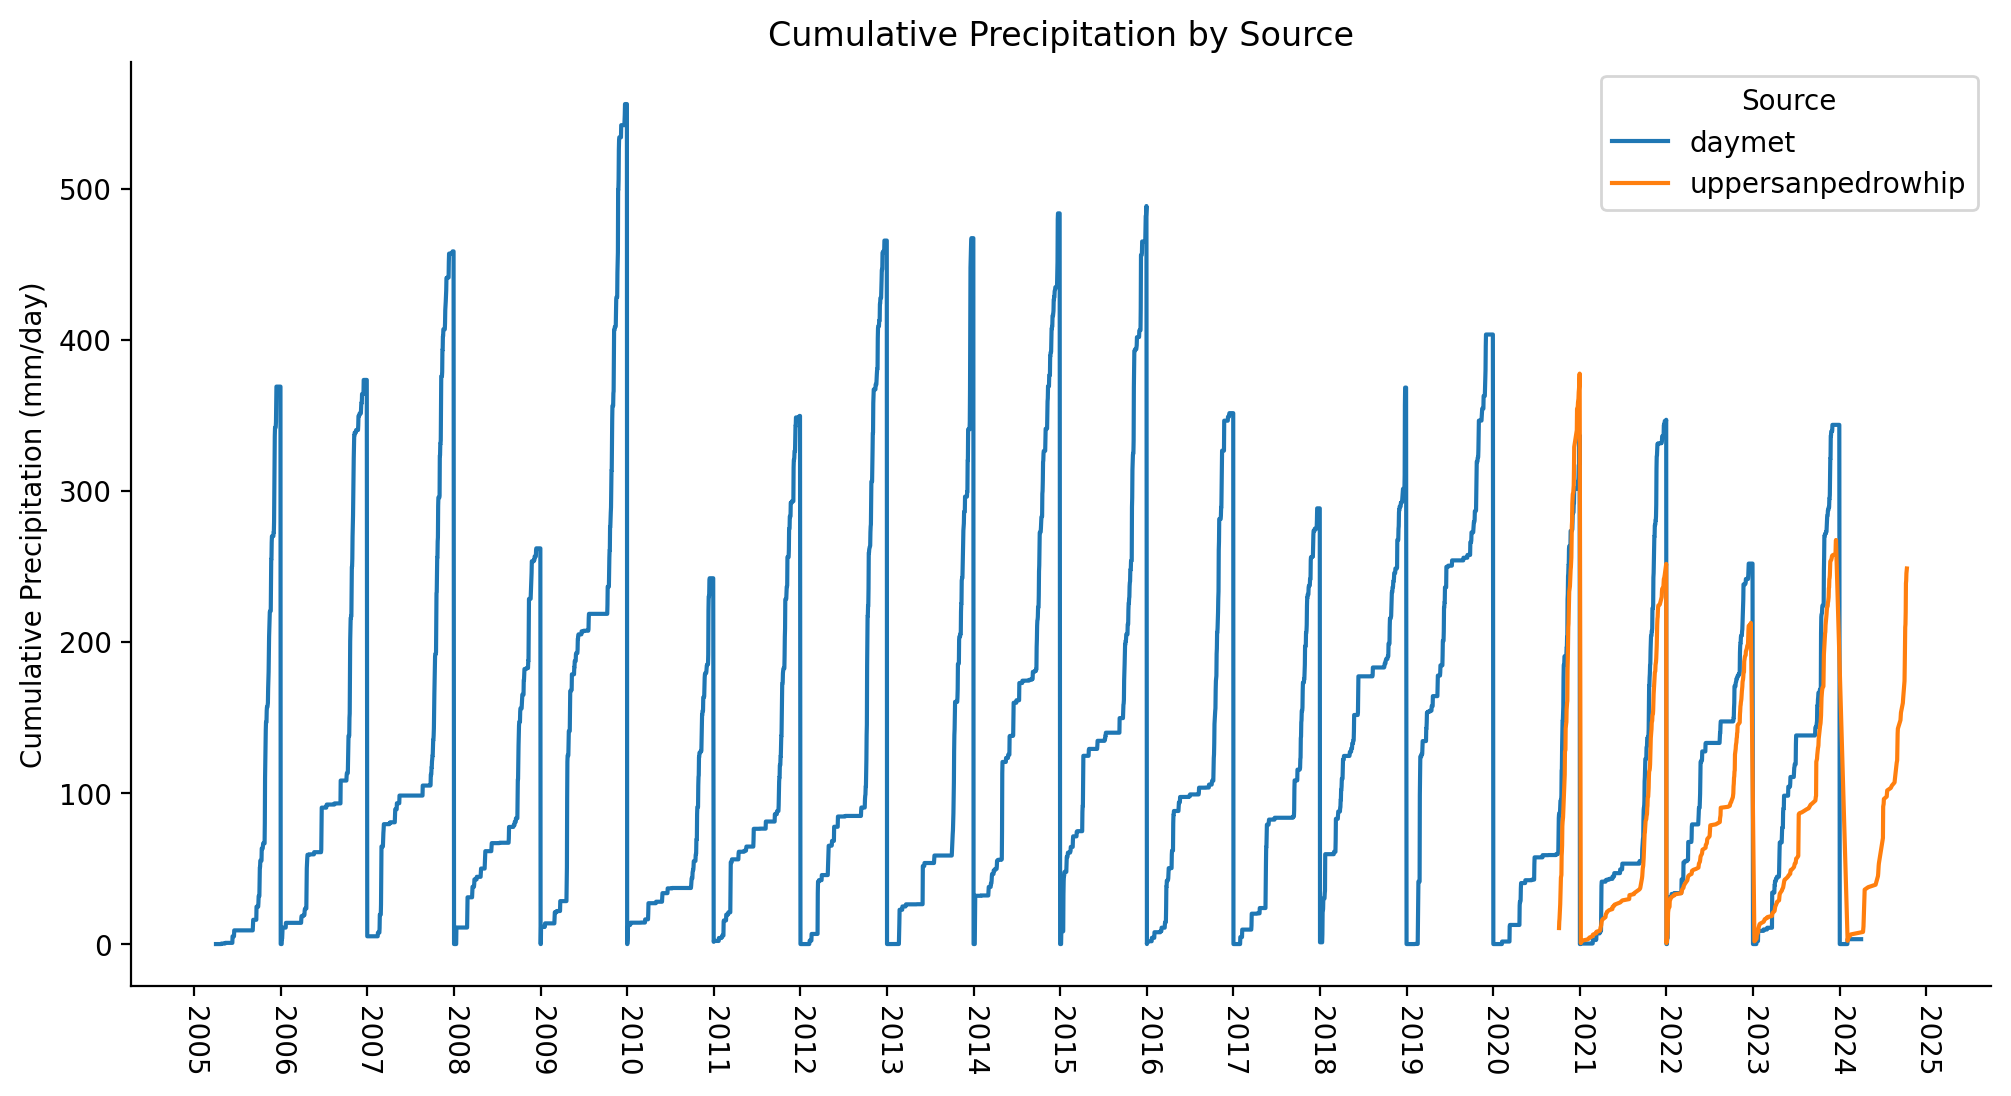

In [30]:
fig, ax = plt.subplots(figsize = (12, 6))
ax.spines[["top", "right"]].set_visible(False)

ax.set_title("Cumulative Precipitation by Source")
ax.set_ylabel("Cumulative Precipitation (mm/day)")

ax.plot(gage_agg["water_date"], gage_agg["Cumulative"], label = "daymet")
ax.plot(daily["water_date"], daily["Cumulative"] * 25.4, label = "uppersanpedrowhip")

ax.set_xticks([pd.Timestamp(f"{y}-01-01") for y in range(2005, 2026)])
ax.set_xticklabels(range(2005, 2026))
ax.tick_params(axis = "x", labelrotation = 270)

ax.legend(title = "Source")

%config InlineBackend.figure_format = "retina"

# plt.savefig("daymet_whip_gage.png", format = "png", dpi = 300, bbox_inches = "tight")

In [31]:
dailygage = daymetgage.groupby(["Water Year", "Date"])["prcp"].mean().reset_index()
wytotalgage = dailygage.groupby("Water Year")["prcp"].sum().reset_index()

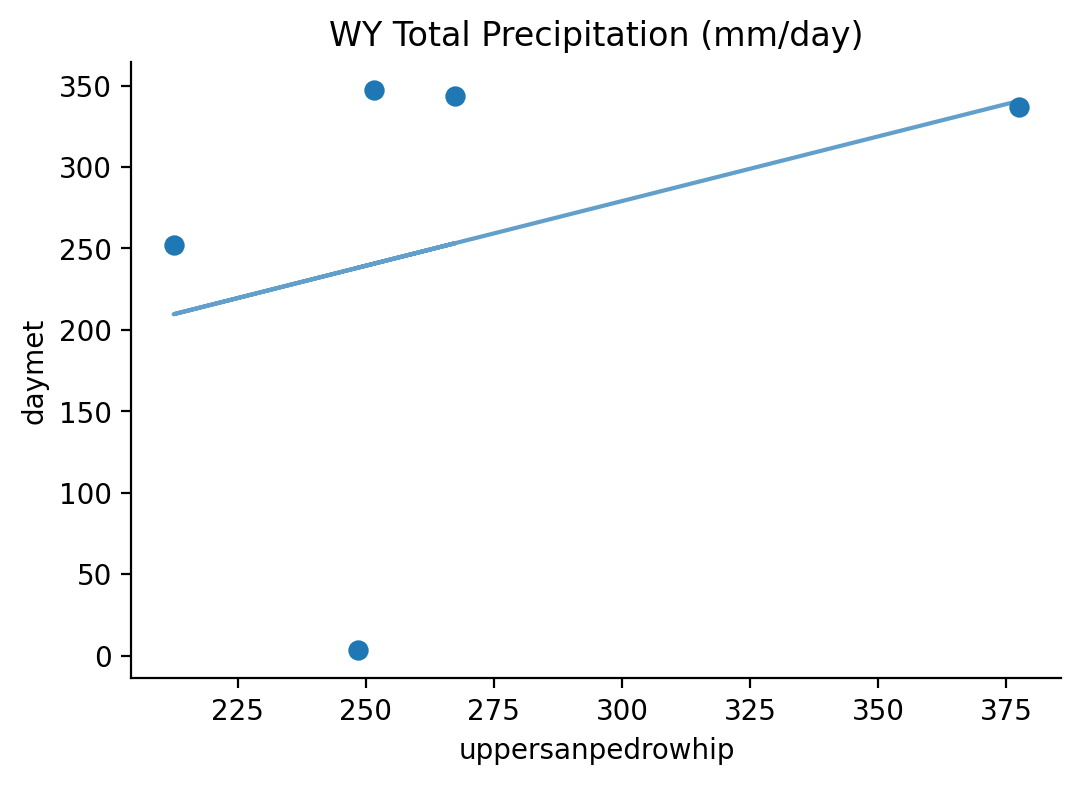

In [32]:
wytg = wytotalgage.merge(whipwytotal[["Water Year", "precipitation"]], on = "Water Year")

fig, ax = plt.subplots(figsize = (6, 4))
ax.spines[["top", "right"]].set_visible(False)

ax.set_title("WY Total Precipitation (mm/day)")
ax.set_ylabel("daymet")
ax.set_xlabel("uppersanpedrowhip")

x = wytg["precipitation"] * 25.4
y = wytg["prcp"]

ax.scatter(x, y, s = 40)
slope, intercept, _, _, _ = linregress(x, y)
fit = intercept + slope * x
ax.plot(x, fit, alpha = 0.7)

%config InlineBackend.figure_format = "retina"

# plt.savefig("daymet_whip_gage_total.png", format = "png", dpi = 300, bbox_inches = "tight")

In [33]:
single = streamflow[streamflow["site_no"] == "09471550"]

In [34]:
sflow = flow
sflow["Water Year"] = sflow.apply(water_year, axis = 1)
sflow["water_date"] = sflow["Date"].apply(water_date)
sflow = pd.merge(sflow, single[["water_date", "00060_Mean"]], on = "water_date", how = "left")

In [35]:
persistence = flow.dropna(subset = ['Flow Code']).assign(Persistence = flow["Flow Code"].isin([1, 2])).groupby("Site").agg(Persistence = ("Persistence", "mean"), Longitude = ("Longitude", "first"), Latitude = ("Latitude", "first")).drop(["Cottonwood", "Escalante", "FairbankNorth"])
persistence = gpd.GeoDataFrame(persistence, geometry = gpd.points_from_xy(persistence["Longitude"], persistence["Latitude"]))

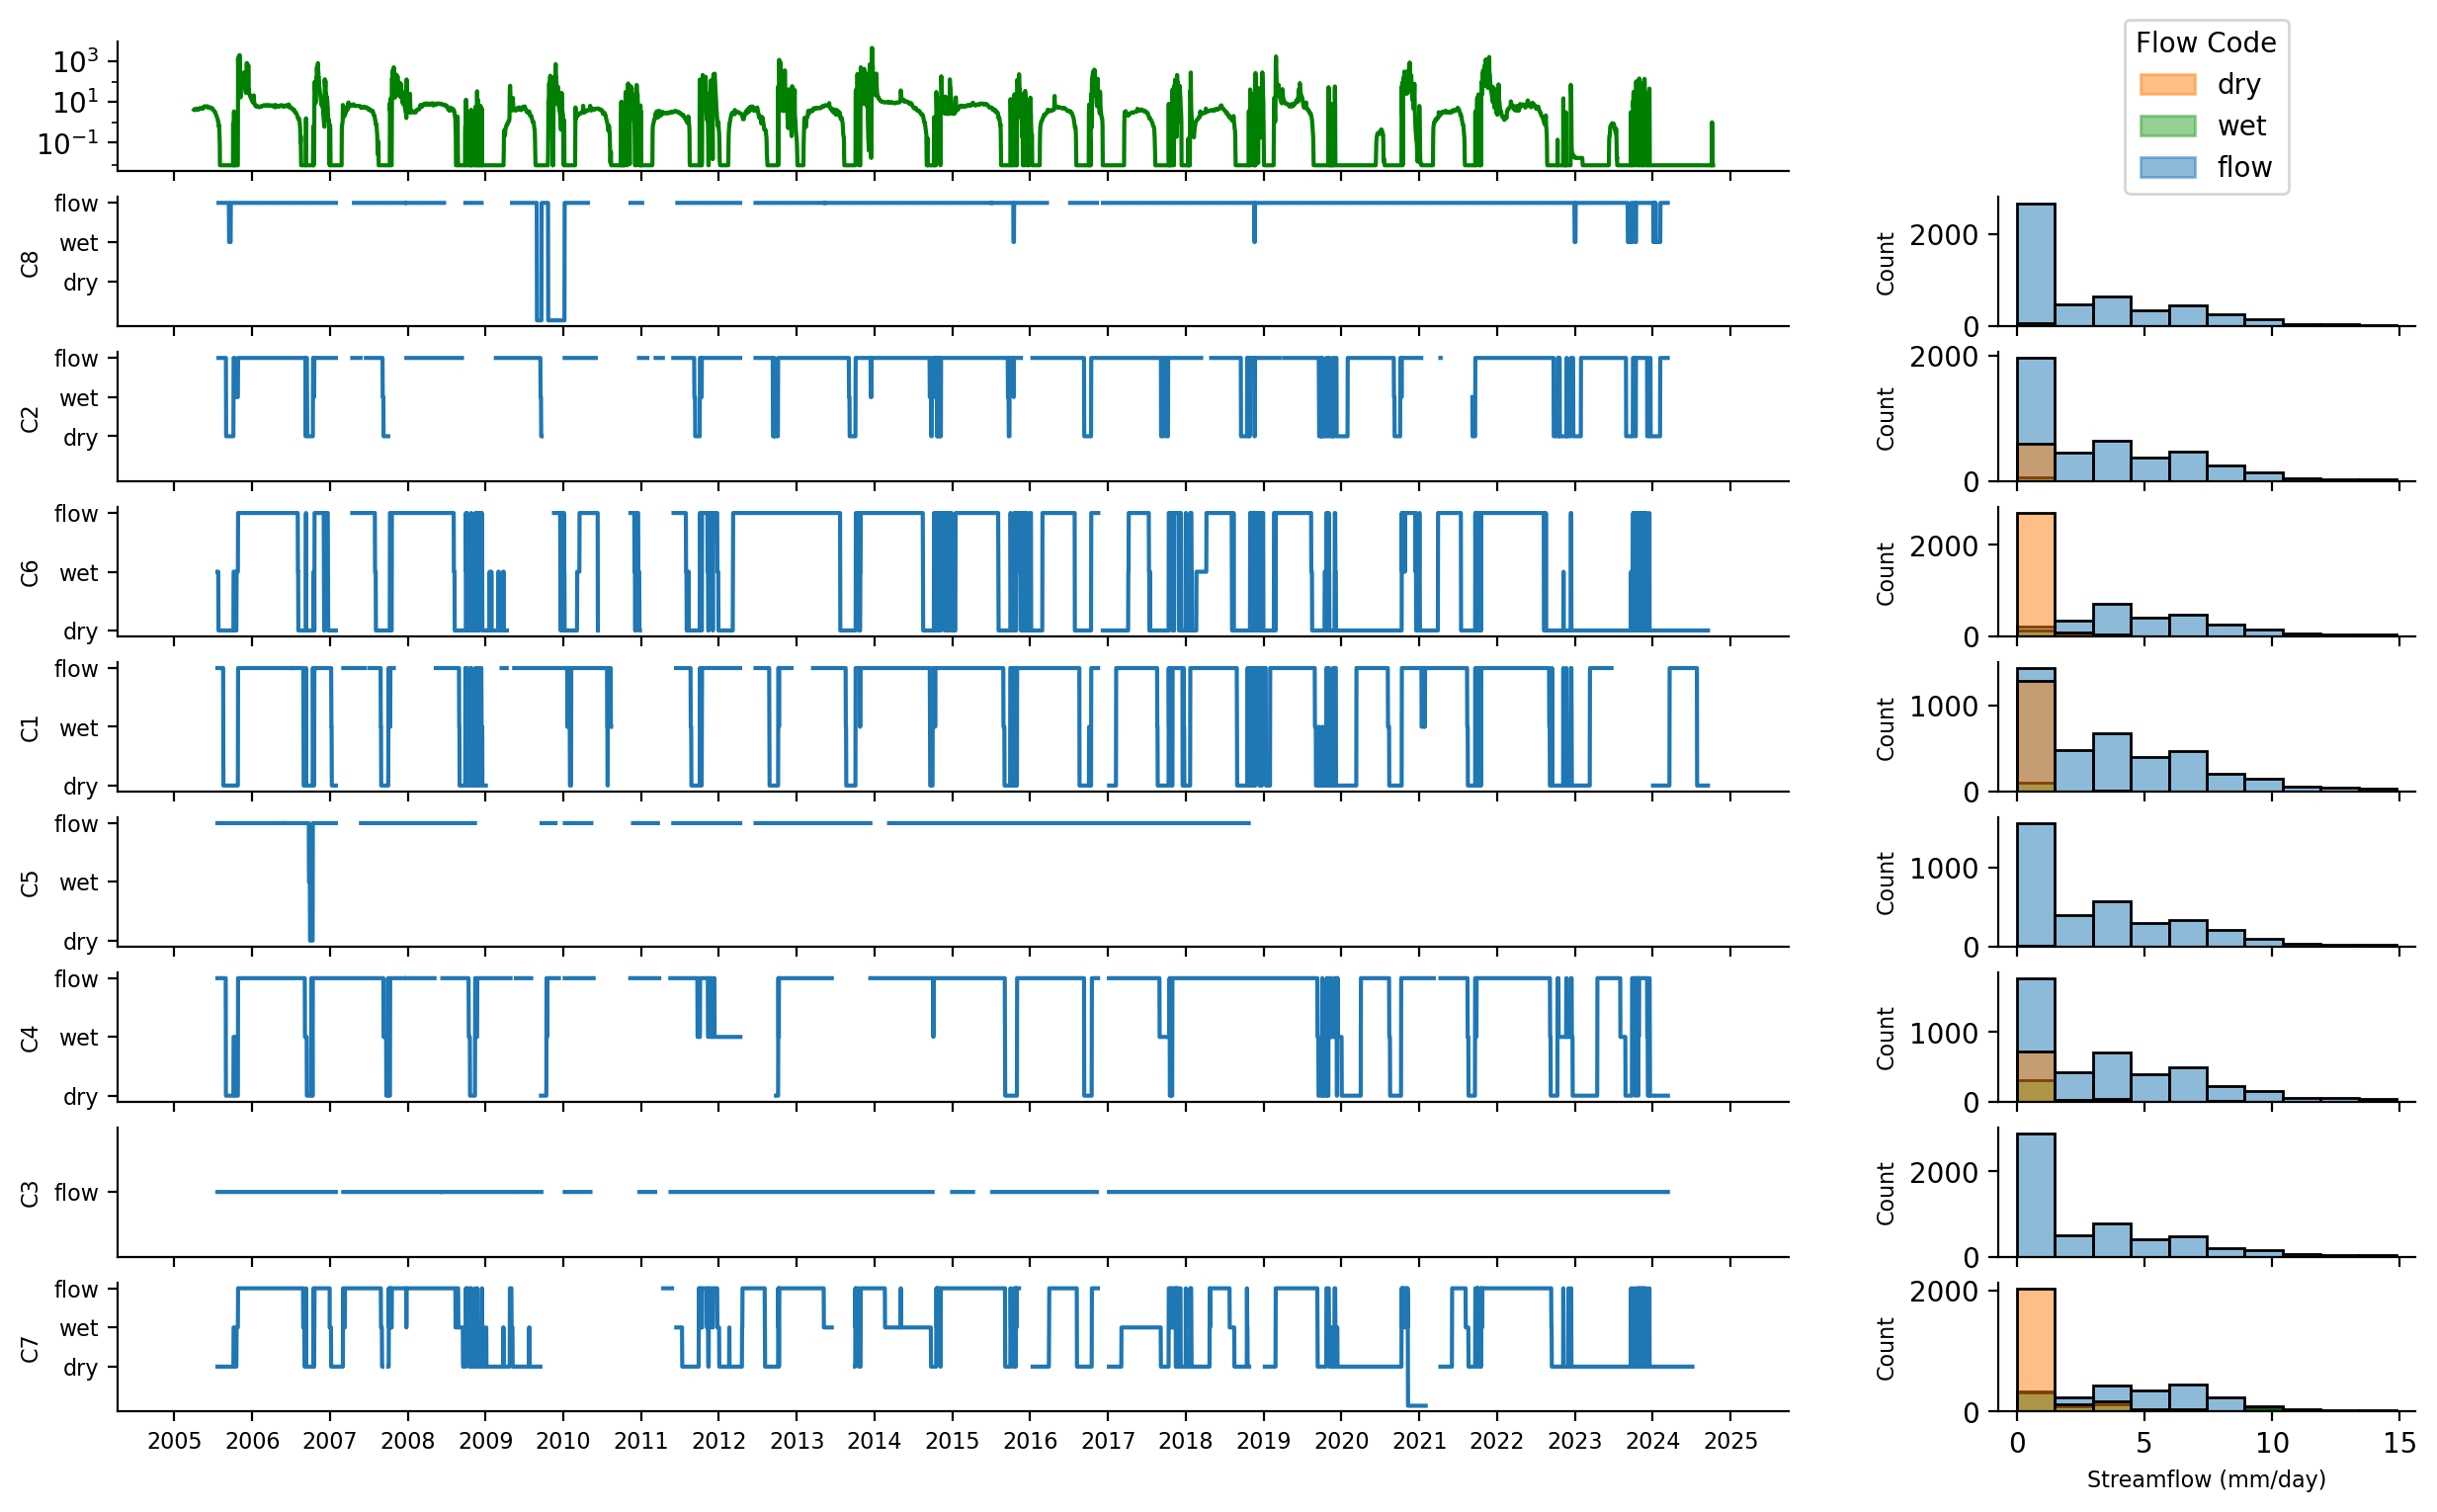

In [36]:
fig, axes = plt.subplots(
    nrows = len(persistence) + 1, ncols = 2,
    figsize = (15, 9),
    gridspec_kw = {"width_ratios": [4,1]},
    sharex = "col"
)

axes[0, 0].plot(single["water_date"], single["00060_Mean"], color = "green")
axes[0, 0].set_yscale("symlog", linthresh = 0.1)
axes[0, 0].set_yticks([0.1, 10, 1000])
axes[0, 0].spines[["top", "right"]].set_visible(False)

palette = {0: sns.color_palette()[1], 1: sns.color_palette()[2], 2: sns.color_palette()[0]}

for i in range(len(old_names.keys())):
    cdata = sflow[sflow["Site"] == list(old_names.keys())[i]]
    axes[i + 1, 0].set_yticks([0, 1, 2])                      # positions
    axes[i + 1, 0].set_yticklabels(["dry","wet","flow"], fontsize = 8)  # labels
    axes[i + 1, 0].plot(cdata["water_date"], cdata["Flow Code"])
    axes[i + 1, 0].set_ylabel("C" + str(old_names[list(old_names.keys())[i]]), fontsize = 8)
    axes[i + 1, 0].spines[["top", "right"]].set_visible(False)

    sub = cdata[cdata["Flow Code"].isin([0, 1, 2])]
    sub = sub[sub["00060_Mean"].notna()]
    sub = sub[sub["00060_Mean"] < 15] # remove outliers

    sns.histplot(data = sub, x = "00060_Mean", hue = "Flow Code", bins = 10, alpha = 0.5, multiple = "layer", ax = axes[i + 1, 1], palette = palette, legend = False)
    axes[i + 1, 1].yaxis.label.set_size(8)

    axes[i + 1, 1].spines[["top", "right"]].set_visible(False)

axes[8, 0].set_xticks([pd.Timestamp(f"{y}-01-01") for y in range(2005, 2026)])
axes[8, 0].set_xticklabels(range(2005, 2026), fontsize = 8)
axes[8, 1].set_xlabel("Streamflow (mm/day)", fontsize = 8)
axes[0, 1].axis("off")

handles = [
    mpatches.Patch(color = palette[0], alpha = 0.5, label = "dry"),
    mpatches.Patch(color = palette[1], alpha = 0.5, label = "wet"),
    mpatches.Patch(color = palette[2], alpha = 0.5, label = "flow")
]

axes[0, 1].legend(handles = handles, labels = ["dry", "wet", "flow"], title = "Flow Code", loc = "center")

%config InlineBackend.figure_format = "retina"

# plt.savefig("streamflow.png", format = "png", dpi = 300, bbox_inches = "tight")